### **1. Bibliotecas**

In [1]:
import os
import json
import numpy as np
import pandas as pd
from scipy import stats
from joblib import dump, load
from openai import OpenAI, AsyncOpenAI
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
import nest_asyncio
import asyncio
nest_asyncio.apply()
from tqdm.notebook import tqdm
tqdm.pandas()
from warnings import filterwarnings
filterwarnings('ignore')

---
### **2. Dataset**

In [21]:
url = os.getenv("URL_DATASET")
df = pd.read_excel(url)
df.head(3)

,Text,Text_PT,Opinion(1/0),Question(1/0),Answer(1/0),Sentiment(1-7),Confusion(1-7),Urgency(1-7),CourseType,forum_post_id,course_display_name,forum_uid,created_at,post_type,anonymous,anonymous_to_peers,up_count,comment_thread_id,reads
0,Interesting! How often we say those things to ...,Interessante! Quantas vezes dizemos essas cois...,1,0,0,6.5,2.0,1.5,Education,5225177f2c501f0a00000015,Education/EDUC115N/How_to_Learn_Math,30CADB93E6DE4711193D7BD05F2AE95C,2013-09-02 22:55:59,Comment,0.0,0.0,0.0,5221a8262cfae31200000001,41.0
1,"What is \Algebra as a Math Game\"" or are you j...",O que é \ Álgebra como um jogo de matemática \...,0,1,0,4.0,5.0,3.5,Education,5207d0e9935dfc0e0000005e,Education/EDUC115N/How_to_Learn_Math,37D8FAEE7D0B94B6CFC57D98FD3D0BA5,2013-08-11 17:59:05,Comment,0.0,0.0,0.0,520663839df35b0a00000043,55.0
2,I like the idea of my kids principal who says ...,Gosto da ideia do diretor dos meus filhos que ...,1,0,0,5.5,3.0,2.5,Education,52052c82d01fec0a00000071,Education/EDUC115N/How_to_Learn_Math,CC11480215042B3EB6E5905EAB13B733,2013-08-09 17:53:06,Comment,0.0,0.0,0.0,51e59415e339d716000001a6,25.0


In [22]:
# nome das colunas em minusculo
df.columns = df.columns.str.lower()

# colunas binárias
df.insert(5, column='sentiment(1/0)', value=df["sentiment(1-7)"].apply(lambda x: 0 if x < 4 else 1))
df.insert(7, column='confusion(1/0)', value=df["confusion(1-7)"].apply(lambda x: 0 if x < 4 else 1))
df.insert(9, column='urgency(1/0)', value=df["urgency(1-7)"].apply(lambda x: 0 if x < 4 else 1))
df.head(2)

,text,text_pt,opinion(1/0),question(1/0),answer(1/0),sentiment(1/0),sentiment(1-7),confusion(1/0),confusion(1-7),urgency(1/0),...,forum_post_id,course_display_name,forum_uid,created_at,post_type,anonymous,anonymous_to_peers,up_count,comment_thread_id,reads
0,Interesting! How often we say those things to ...,Interessante! Quantas vezes dizemos essas cois...,1,0,0,1,6.5,0,2.0,0,...,5225177f2c501f0a00000015,Education/EDUC115N/How_to_Learn_Math,30CADB93E6DE4711193D7BD05F2AE95C,2013-09-02 22:55:59,Comment,0.0,0.0,0.0,5221a8262cfae31200000001,41.0
1,"What is \Algebra as a Math Game\"" or are you j...",O que é \ Álgebra como um jogo de matemática \...,0,1,0,1,4.0,1,5.0,0,...,5207d0e9935dfc0e0000005e,Education/EDUC115N/How_to_Learn_Math,37D8FAEE7D0B94B6CFC57D98FD3D0BA5,2013-08-11 17:59:05,Comment,0.0,0.0,0.0,520663839df35b0a00000043,55.0


In [25]:
dump(df, "data/df_stanford.z")

['data/df_stanford.z']

---
### **3. Dataframe salvo**

In [2]:
df = load('data/df_stanford.z')
df.head(2)

,text,text_pt,opinion(1/0),question(1/0),answer(1/0),sentiment(1/0),sentiment(1/0)GPT,sentiment(1-7),sentiment(1-7)GPT,confusion(1/0),...,forum_post_id,course_display_name,forum_uid,created_at,post_type,anonymous,anonymous_to_peers,up_count,comment_thread_id,reads
0,Interesting! How often we say those things to ...,Interessante! Quantas vezes dizemos essas cois...,1,0,0,1,1,6.5,6.5,0,...,5225177f2c501f0a00000015,Education/EDUC115N/How_to_Learn_Math,30CADB93E6DE4711193D7BD05F2AE95C,2013-09-02 22:55:59,Comment,0.0,0.0,0.0,5221a8262cfae31200000001,41.0
1,"What is \Algebra as a Math Game\"" or are you j...",O que é \ Álgebra como um jogo de matemática \...,0,1,0,1,0,4.0,3.5,1,...,5207d0e9935dfc0e0000005e,Education/EDUC115N/How_to_Learn_Math,37D8FAEE7D0B94B6CFC57D98FD3D0BA5,2013-08-11 17:59:05,Comment,0.0,0.0,0.0,520663839df35b0a00000043,55.0


---
### **4. Rótulos de Sentimentos**

In [28]:
np.sort(df['sentiment(1-7)'].unique())

array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. ])

---
#### **4.1 Rotulando um post com GPT**

In [ ]:
def gpt_label(text):
    try:
        response = client.chat.completions.create(
            # model="gpt-3.5-turbo",
            # model="gpt-4o",
            model="gpt-4o-mini",
            max_tokens=3,
            store=True,
            messages=[
                {
                    "role": "user",
                    "content": f"You are a data scientist who labels texts regarding sentiment with one of the options [1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. ], with 1 being very negative sentiment and up to 7 being very positive sentiment. Answer only one number and label the following text: {text}",
                },
            ],
        )
        return response.choices[0].message
    except Exception as e:
        print(f'Erro ao rotular: {str(e)}')
        return 0

In [32]:
indice_escolhido = 0
rotulo = float(gpt_label(df["text"][indice_escolhido]).content)
print(f'Rótulo escolhido pelo GPT: {rotulo}')
print('-'*50)
print('Post:')
print(df[["text", "sentiment(1-7)"]].iloc[indice_escolhido]['text'])
print('Rótulo real: ', df[["text", "sentiment(1-7)"]].iloc[indice_escolhido]["sentiment(1-7)"])

Rótulo escolhido pelo GPT: 6.5
--------------------------------------------------
Post:
Interesting! How often we say those things to others without really understanding what we are saying. That must have been a powerful experience! Excellent!
Rótulo real:  6.5


In [33]:
df[["text", "sentiment(1-7)"]]

,text,sentiment(1-7)
0,Interesting! How often we say those things to ...,6.5
1,"What is \Algebra as a Math Game\"" or are you j...",4.0
2,I like the idea of my kids principal who says ...,5.5
3,"From their responses, it seems the students re...",6.0
4,"The boys loved math, because \there is freedom...",7.0
...,...,...
29599,The p value tells us the probability of observ...,4.0
29600,given the null hypothesis is considered true,4.0
29601,"> Hello Josh,_x0007__x0007_Is this hypothesis ...",4.0
29602,"Hi Josh,_x0007__x0007__x0007__x0007_Looking at...",3.5


---
#### **4.2 Rotulando dataset completo com GPT**

In [ ]:
client_async = AsyncOpenAI(api_key=os.getenv("OPENAI_API_KEY"))

async def gpt_label_async(text):
    try:
        response = await client_async.chat.completions.create(
            # model="gpt-3.5-turbo",
            # model="gpt-4o",
            model="gpt-4o-mini",
            max_tokens=3,
            store=True,
            messages=[
                {
                    "role": "user",
                    "content": f"You are a data scientist who labels texts regarding sentiment with one of the options [1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. ], with 1 being very negative sentiment and up to 7 being very positive sentiment. Answer only one number and label the following text: {text}",
                },
            ],
        )
        return response.choices[0].message
    except Exception as e:
        print(f'Erro ao rotular: {str(e)}')
        return 0

In [ ]:
intervalo = range(0, 10)
rotulos = df["text"][intervalo].progress_apply(lambda x: asyncio.run(gpt_label_async(x)))
rotulos = rotulos.map(lambda x: float(x.content))

In [ ]:
# Realizar o teste t de Student
t_stat, p_value = stats.ttest_ind(df["sentiment(1-7)"][intervalo], rotulos)

print(f"Estatística t: {t_stat}")
print(f"Valor p: {p_value}")

# Verificar a significância
print(f"{'Há' if p_value < 0.05 else 'Não há'} uma diferença significativa entre os rótulos reais e preditos.")

Estatística t: 0.30738931174713624
Valor p: 0.7620751630156286
Não há uma diferença significativa entre os rótulos reais e preditos.


#### **4.3 Rotulando dataset completo com Batch API GPT**

In [ ]:
# criando lista para arquivo jsonl com os prompts para cada post
prompts = []
def create_jsonl(idx, text):
    prompts.append(
        {
            "custom_id": f"request-{idx}",
            "method": "POST",
            "url": "/v1/chat/completions",
            "body": {
                "model": "gpt-4o-mini",
                "messages": [
                    {
                        "role": "user",
                        "content": f"You are a data scientist who labels texts regarding sentiment with one of the options [1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. ], with 1 being very negative sentiment and up to 7 being very positive sentiment. Answer only one number and label the following text: {text}",
                    },
                ],
                "max_tokens": 3,
            },
        }
    )

# intervalo, arquivo, resultado = range(0, 10000), "data/sentiment/prompts1.jsonl", "data/sentiment/resultados1.jsonl"
# intervalo, arquivo, resultado = range(10000, 15000), "data/sentiment/prompts2.jsonl", "data/sentiment/resultados2.jsonl"
# intervalo, arquivo, resultado = range(15000, 20000), "data/sentiment/prompts3.jsonl", "data/sentiment/resultados3.jsonl"
# intervalo, arquivo, resultado = range(20000, 25000), "data/sentiment/prompts4.jsonl", "data/sentiment/resultados4.jsonl"
intervalo, arquivo, resultado = range(25000, 29604), "data/sentiment/prompts5.jsonl", "data/sentiment/resultados5.jsonl"

for idx, text in zip(intervalo,df['text'][intervalo]):
    create_jsonl(idx, text)

# salvando arquivo jsonl com os prompts
with open(arquivo, "w", encoding="utf-8") as file:
    for entry in prompts:
        file.write(json.dumps(entry) + "\n")

# enviando arquivo jsonl para API
batch_input_file = client.files.create(file=open(arquivo, "rb"), purpose="batch")

# criando o lote do arquivo jsonl
batch = client.batches.create(
    input_file_id=batch_input_file.id,
    endpoint="/v1/chat/completions",
    completion_window="24h",
    metadata={"description": f"gpt label dataset {arquivo}"},
)

batch.to_dict()

{'id': 'batch_67f3264d34388190ab673981627e0dd4',
 'completion_window': '24h',
 'created_at': 1743988301,
 'endpoint': '/v1/chat/completions',
 'input_file_id': 'file-WcCu1nXH188WeTka4koWzf',
 'object': 'batch',
 'status': 'validating',
 'cancelled_at': None,
 'cancelling_at': None,
 'completed_at': None,
 'error_file_id': None,
 'errors': None,
 'expired_at': None,
 'expires_at': 1744074701,
 'failed_at': None,
 'finalizing_at': None,
 'in_progress_at': None,
 'metadata': {'description': 'gpt label dataset data/prompts5.jsonl'},
 'output_file_id': None,
 'request_counts': {'completed': 0, 'failed': 0, 'total': 0}}

In [176]:
# listar último lote
client.batches.list(limit=1).to_dict()['data'][0]

{'id': 'batch_67f3264d34388190ab673981627e0dd4',
 'completion_window': '24h',
 'created_at': 1743988301,
 'endpoint': '/v1/chat/completions',
 'input_file_id': 'file-WcCu1nXH188WeTka4koWzf',
 'object': 'batch',
 'status': 'completed',
 'cancelled_at': None,
 'cancelling_at': None,
 'completed_at': 1743989458,
 'error_file_id': None,
 'errors': None,
 'expired_at': None,
 'expires_at': 1744074701,
 'failed_at': None,
 'finalizing_at': 1743989172,
 'in_progress_at': 1743988303,
 'metadata': {'description': 'gpt label dataset data/prompts5.jsonl'},
 'output_file_id': 'file-9nPLL1DtMhHZAaDGDLA2uC',
 'request_counts': {'completed': 4604, 'failed': 0, 'total': 4604}}

In [82]:
# verificar situação do lote - outra opção se souber o id do lote
client.batches.retrieve(batch.to_dict()["id"]).to_dict()

{'id': 'batch_67f3264d34388190ab673981627e0dd4',
 'completion_window': '24h',
 'created_at': 1743988301,
 'endpoint': '/v1/chat/completions',
 'input_file_id': 'file-WcCu1nXH188WeTka4koWzf',
 'object': 'batch',
 'status': 'completed',
 'cancelled_at': None,
 'cancelling_at': None,
 'completed_at': 1743989458,
 'error_file_id': None,
 'errors': None,
 'expired_at': None,
 'expires_at': 1744074701,
 'failed_at': None,
 'finalizing_at': 1743989172,
 'in_progress_at': 1743988303,
 'metadata': {'description': 'gpt label dataset data/prompts5.jsonl'},
 'output_file_id': 'file-9nPLL1DtMhHZAaDGDLA2uC',
 'request_counts': {'completed': 4604, 'failed': 0, 'total': 4604}}

In [ ]:
# pegar resultado do lote
output_file_id = client.batches.retrieve(batch.to_dict()["id"]).to_dict()["output_file_id"]

file_response = client.files.content(output_file_id)
file_response.write_to_file(resultado)

#### **4.4 Tratamento dos resultados**

In [ ]:
def get_labels(caminho_arquivo):        
    dados = []
    with open(caminho_arquivo, "r", encoding="utf-8") as file:
        for linha in file:
            dados.append(json.loads(linha))

    rotulos = []
    for i in range(len(dados)):
        try:
            rotulos.append(float(dados[i]["response"]["body"]["choices"][0]["message"]["content"]))           
        except ValueError:
            rotulos.append(4.0)

    return rotulos

r1 = get_labels("data/sentiment/resultados1.jsonl")
r2 = get_labels("data/sentiment/resultados2.jsonl")
r3 = get_labels("data/sentiment/resultados3.jsonl")
r4 = get_labels("data/sentiment/resultados4.jsonl")
r5 = get_labels("data/sentiment/resultados5.jsonl")

def diferenca_percentual(df_labels, gpt_labels):    
    for i in range(len(df_labels)):
        percentual = np.abs((gpt_labels[i] - df_labels[i]) / df_labels[i]) * 100
        if percentual <= 25:
            gpt_labels[i] = df_labels[i]

    return gpt_labels

gpt_labels = diferenca_percentual(df["sentiment(1-7)"], pd.Series(r1 + r2 + r3 + r4 + r5))
df.insert(6, column="sentiment(1/0)GPT", value=gpt_labels.apply(lambda x: 0 if x < 4 else 1))
df.insert(8, column="sentiment(1-7)GPT", value=gpt_labels)
df.columns

Index(['text', 'text_pt', 'opinion(1/0)', 'question(1/0)', 'answer(1/0)',
       'sentiment(1/0)', 'sentiment(1/0)GPT', 'sentiment(1-7)',
       'sentiment(1-7)GPT', 'confusion(1/0)', 'confusion(1-7)', 'urgency(1/0)',
       'urgency(1-7)', 'coursetype', 'forum_post_id', 'course_display_name',
       'forum_uid', 'created_at', 'post_type', 'anonymous',
       'anonymous_to_peers', 'up_count', 'comment_thread_id', 'reads'],
      dtype='object')

              precision    recall  f1-score   support

           0       0.60      0.86      0.71      4387
           1       0.97      0.90      0.94     25217

    accuracy                           0.89     29604
   macro avg       0.79      0.88      0.82     29604
weighted avg       0.92      0.89      0.90     29604



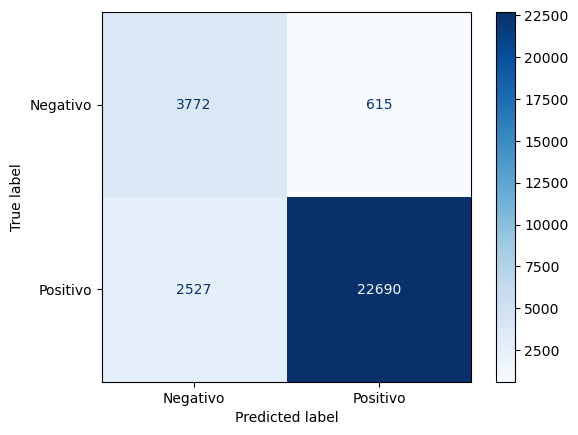

In [38]:
# calcular metricas dos rotulos
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
cf = confusion_matrix(df["sentiment(1/0)"], df["sentiment(1/0)GPT"])
ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=["Negativo", "Positivo"]).plot(cmap="Blues")
print(classification_report(df["sentiment(1/0)"], df["sentiment(1/0)GPT"]))

### **5. Rótulos de Confusão**

In [54]:
np.sort(df["confusion(1-7)"].unique())

array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. ])

#### **5.1 Rotulando dataset completo com Batch API GPT**

In [ ]:
# criando lista para arquivo jsonl com os prompts para cada post
prompts = []
def create_jsonl(idx, text):
    prompts.append(
        {
            "custom_id": f"request-{idx}",
            "method": "POST",
            "url": "/v1/chat/completions",
            "body": {
                "model": "gpt-4o-mini",
                "messages": [
                    {
                        "role": "user",
                        "content": f"You are a data scientist who labels texts regarding confusion with one of the options [1.0 , 1.5, 2.0 , 2.5, 3.0 , 3.5, 4.0 , 4.5, 5.0 , 5.5, 6.0 , 6.5, 7.0 ], with 1 being very low confusion and up to 7 being very high confusion. Answer with only one of number option showed and label the following text: {text}",
                    },
                ],
                "max_tokens": 3,
            },
        }
    )

# intervalo, arquivo, resultado = range(0, 5000), "data/confusion/prompts1.jsonl", "data/confusion/resultados1.jsonl"
# intervalo, arquivo, resultado = range(5000, 10000), "data/confusion/prompts2.jsonl", "data/confusion/resultados2.jsonl"
# intervalo, arquivo, resultado = range(10000, 15000), "data/confusion/prompts3.jsonl", "data/confusion/resultados3.jsonl"
# intervalo, arquivo, resultado = range(15000, 20000), "data/confusion/prompts4.jsonl", "data/confusion/resultados4.jsonl"
# intervalo, arquivo, resultado = range(20000, 25000), "data/confusion/prompts5.jsonl", "data/confusion/resultados5.jsonl"
intervalo, arquivo, resultado = range(25000, 29604), "data/confusion/prompts6.jsonl", "data/confusion/resultados6.jsonl"

for idx, text in zip(intervalo,df['text'][intervalo]):
    create_jsonl(idx, text)

# salvando arquivo jsonl com os prompts
with open(arquivo, "w", encoding="utf-8") as file:
    for entry in prompts:
        file.write(json.dumps(entry) + "\n")

# enviando arquivo jsonl para API
batch_input_file = client.files.create(file=open(arquivo, "rb"), purpose="batch")

# criando o lote do arquivo jsonl
batch = client.batches.create(
    input_file_id=batch_input_file.id,
    endpoint="/v1/chat/completions",
    completion_window="24h",
    metadata={"description": f"gpt label dataset {arquivo}"},
)

dump(batch.to_dict(), "data/batch.z")
dump(resultado, 'data/resultado.z')
batch.to_dict()

{'id': 'batch_680a45a227c481908fd31ff35475501c',
 'completion_window': '24h',
 'created_at': 1745503650,
 'endpoint': '/v1/chat/completions',
 'input_file_id': 'file-2jfX29qoAC87U4g5rMX1hD',
 'object': 'batch',
 'status': 'validating',
 'cancelled_at': None,
 'cancelling_at': None,
 'completed_at': None,
 'error_file_id': None,
 'errors': None,
 'expired_at': None,
 'expires_at': 1745590050,
 'failed_at': None,
 'finalizing_at': None,
 'in_progress_at': None,
 'metadata': {'description': 'gpt label dataset data/confusion/prompts6.jsonl'},
 'output_file_id': None,
 'request_counts': {'completed': 0, 'failed': 0, 'total': 0}}

In [3]:
# verificar situação do lote - outra opção se souber o id do lote
batch = load("data/batch.z")
client.batches.retrieve(batch["id"]).to_dict()

{'id': 'batch_680a45a227c481908fd31ff35475501c',
 'completion_window': '24h',
 'created_at': 1745503650,
 'endpoint': '/v1/chat/completions',
 'input_file_id': 'file-2jfX29qoAC87U4g5rMX1hD',
 'object': 'batch',
 'status': 'completed',
 'cancelled_at': None,
 'cancelling_at': None,
 'completed_at': 1745522303,
 'error_file_id': None,
 'errors': None,
 'expired_at': None,
 'expires_at': 1745590050,
 'failed_at': None,
 'finalizing_at': 1745521795,
 'in_progress_at': 1745503651,
 'metadata': {'description': 'gpt label dataset data/confusion/prompts6.jsonl'},
 'output_file_id': 'file-7GKt4vxHDH78Drfe9Rqeqr',
 'request_counts': {'completed': 4604, 'failed': 0, 'total': 4604}}

In [4]:
# pegar resultado do lote
resultado = load('data/resultado.z')
output_file_id = client.batches.retrieve(batch["id"]).to_dict()["output_file_id"]
file_response = client.files.content(output_file_id)
file_response.write_to_file(resultado)

#### **5.2 Tratamento dos resultados**

In [ ]:
def get_labels(caminho_arquivo):        
    dados = []
    with open(caminho_arquivo, "r", encoding="utf-8") as file:
        for linha in file:
            dados.append(json.loads(linha))

    rotulos = []
    for i in range(len(dados)):
        try:
            rotulos.append(float(dados[i]["response"]["body"]["choices"][0]["message"]["content"]))           
        except ValueError:
            rotulos.append(4.0)

    return rotulos

r1 = get_labels("data/confusion/resultados1.jsonl")
r2 = get_labels("data/confusion/resultados2.jsonl")
r3 = get_labels("data/confusion/resultados3.jsonl")
r4 = get_labels("data/confusion/resultados4.jsonl")
r5 = get_labels("data/confusion/resultados5.jsonl")
r6 = get_labels("data/confusion/resultados6.jsonl")

def diferenca_percentual(df_labels, gpt_labels):    
    for i in range(len(df_labels)):
        percentual = np.abs((gpt_labels[i] - df_labels[i]) / df_labels[i]) * 100
        if percentual <= 25:
            gpt_labels[i] = df_labels[i]

    return gpt_labels

gpt_labels = diferenca_percentual(df["confusion(1-7)"], pd.Series(r1 + r2 + r3 + r4 + r5 + r6))
df.insert(10, column="confusion(1/0)GPT", value=gpt_labels.apply(lambda x: 0 if x < 4 else 1))
df.insert(12, column="confusion(1-7)GPT", value=gpt_labels)
df.columns

Index(['text', 'text_pt', 'opinion(1/0)', 'question(1/0)', 'answer(1/0)',
       'sentiment(1/0)', 'sentiment(1/0)GPT', 'sentiment(1-7)',
       'sentiment(1-7)GPT', 'confusion(1/0)', 'confusion(1/0)GPT',
       'confusion(1-7)', 'confusion(1-7)GPT', 'urgency(1/0)', 'urgency(1-7)',
       'coursetype', 'forum_post_id', 'course_display_name', 'forum_uid',
       'created_at', 'post_type', 'anonymous', 'anonymous_to_peers',
       'up_count', 'comment_thread_id', 'reads'],
      dtype='object')

In [41]:
dump(df, "data/df_stanford.z")

['data/df_stanford.z']

              precision    recall  f1-score   support

           0       0.42      0.89      0.57      9654
           1       0.89      0.41      0.56     19950

    accuracy                           0.57     29604
   macro avg       0.65      0.65      0.56     29604
weighted avg       0.73      0.57      0.56     29604



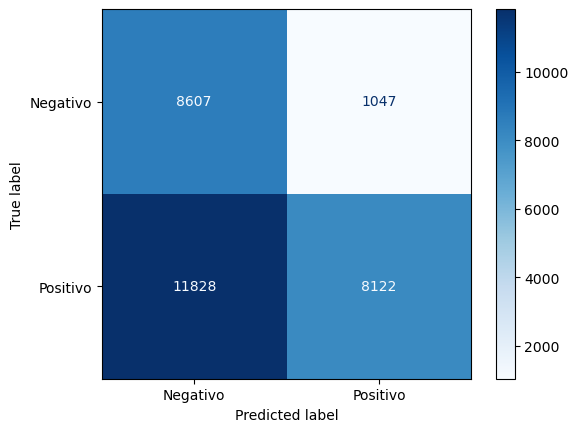

In [40]:
# calcular metricas dos rotulos
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
cf = confusion_matrix(df["confusion(1/0)"], df["confusion(1/0)GPT"])
ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=["Negativo", "Positivo"]).plot(cmap="Blues")
print(classification_report(df["confusion(1/0)"], df["confusion(1/0)GPT"]))

### **6. Rótulos de Urgência**

In [19]:
np.unique(df["urgency(1-7)"].unique())

array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. ])

#### **6.1 Rotulando dataset completo com Batch API GPT**

In [21]:
# criando lista para arquivo jsonl com os prompts para cada post
prompts = []
def create_jsonl(idx, text):
    prompts.append(
        {
            "custom_id": f"request-{idx}",
            "method": "POST",
            "url": "/v1/chat/completions",
            "body": {
                "model": "gpt-4o-mini",
                "messages": [
                    {
                        "role": "user",
                        "content": f"You are a data scientist who labels texts regarding urgency with one of the options [1.0 , 1.5, 2.0 , 2.5, 3.0 , 3.5, 4.0 , 4.5, 5.0 , 5.5, 6.0 , 6.5, 7.0 ], with 1 being few urgency and up to 7 being very urgency. Answer with only one of number option showed and label the following text: {text}",
                    },
                ],
                "max_tokens": 3,
            },
        }
    )

intervalo, arquivo, resultado = range(0, 5000), "data/urgency/prompts1.jsonl", "data/urgency/resultados1.jsonl"
# intervalo, arquivo, resultado = range(5000, 10000), "data/urgency/prompts2.jsonl", "data/urgency/resultados2.jsonl"
# intervalo, arquivo, resultado = range(10000, 15000), "data/urgency/prompts3.jsonl", "data/urgency/resultados3.jsonl"
# intervalo, arquivo, resultado = range(15000, 20000), "data/urgency/prompts4.jsonl", "data/urgency/resultados4.jsonl"
# intervalo, arquivo, resultado = range(20000, 25000), "data/urgency/prompts5.jsonl", "data/urgency/resultados5.jsonl"
# intervalo, arquivo, resultado = range(25000, 29604), "data/urgency/prompts6.jsonl", "data/urgency/resultados6.jsonl"

for idx, text in zip(intervalo,df['text'][intervalo]):
    create_jsonl(idx, text)

# salvando arquivo jsonl com os prompts
with open(arquivo, "w", encoding="utf-8") as file:
    for entry in prompts:
        file.write(json.dumps(entry) + "\n")

# enviando arquivo jsonl para API
batch_input_file = client.files.create(file=open(arquivo, "rb"), purpose="batch")

# criando o lote do arquivo jsonl
batch = client.batches.create(
    input_file_id=batch_input_file.id,
    endpoint="/v1/chat/completions",
    completion_window="24h",
    metadata={"description": f"gpt label dataset {arquivo}"},
)

dump(batch.to_dict(), "data/batch.z")
dump(resultado, 'data/resultado.z')
batch.to_dict()

{'id': 'batch_680ab6f8c3408190a5f6773b4c3085b7',
 'completion_window': '24h',
 'created_at': 1745532664,
 'endpoint': '/v1/chat/completions',
 'input_file_id': 'file-Hbip12h5nWmePYebHhQJtZ',
 'object': 'batch',
 'status': 'validating',
 'cancelled_at': None,
 'cancelling_at': None,
 'completed_at': None,
 'error_file_id': None,
 'errors': None,
 'expired_at': None,
 'expires_at': 1745619064,
 'failed_at': None,
 'finalizing_at': None,
 'in_progress_at': None,
 'metadata': {'description': 'gpt label dataset data/urgency/prompts1.jsonl'},
 'output_file_id': None,
 'request_counts': {'completed': 0, 'failed': 0, 'total': 0}}

In [56]:
# verificar situação do lote - outra opção se souber o id do lote
batch = load("data/batch.z")
client.batches.retrieve(batch["id"]).to_dict()

{'id': 'batch_680ab6f8c3408190a5f6773b4c3085b7',
 'completion_window': '24h',
 'created_at': 1745532664,
 'endpoint': '/v1/chat/completions',
 'input_file_id': 'file-Hbip12h5nWmePYebHhQJtZ',
 'object': 'batch',
 'status': 'in_progress',
 'cancelled_at': None,
 'cancelling_at': None,
 'completed_at': None,
 'error_file_id': None,
 'errors': None,
 'expired_at': None,
 'expires_at': 1745619064,
 'failed_at': None,
 'finalizing_at': None,
 'in_progress_at': 1745532666,
 'metadata': {'description': 'gpt label dataset data/urgency/prompts1.jsonl'},
 'output_file_id': None,
 'request_counts': {'completed': 0, 'failed': 0, 'total': 5000}}

In [ ]:
# pegar resultado do lote
resultado = load("data/resultado.z")
output_file_id = client.batches.retrieve(batch["id"]).to_dict()["output_file_id"]
file_response = client.files.content(output_file_id)
file_response.write_to_file(resultado)

#### **6.2 Tratamento dos resultados**

In [ ]:
def get_labels(caminho_arquivo):        
    dados = []
    with open(caminho_arquivo, "r", encoding="utf-8") as file:
        for linha in file:
            dados.append(json.loads(linha))

    rotulos = []
    for i in range(len(dados)):
        try:
            rotulos.append(float(dados[i]["response"]["body"]["choices"][0]["message"]["content"]))           
        except ValueError:
            rotulos.append(4.0)

    return rotulos

r1 = get_labels("data/urgency/resultados1.jsonl")
r2 = get_labels("data/urgency/resultados2.jsonl")
r3 = get_labels("data/urgency/resultados3.jsonl")
r4 = get_labels("data/urgency/resultados4.jsonl")
r5 = get_labels("data/urgency/resultados5.jsonl")
r6 = get_labels("data/urgency/resultados6.jsonl")

def diferenca_percentual(df_labels, gpt_labels):    
    for i in range(len(df_labels)):
        percentual = np.abs((gpt_labels[i] - df_labels[i]) / df_labels[i]) * 100
        if percentual <= 25:
            gpt_labels[i] = df_labels[i]

    return gpt_labels

gpt_labels = diferenca_percentual(df["urgency(1-7)"], pd.Series(r1 + r2 + r3 + r4 + r5 + r6))
df.insert(10, column="urgency(1/0)GPT", value=gpt_labels.apply(lambda x: 0 if x < 4 else 1))
df.insert(12, column="urgency(1-7)GPT", value=gpt_labels)
df.columns

In [ ]:
dump(df, "data/df_stanford.z")

In [ ]:
# calcular metricas dos rotulos
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
cf = confusion_matrix(df["urgency(1/0)"], df["urgency(1/0)GPT"])
ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=["Negativo", "Positivo"]).plot(cmap="Blues")
print(classification_report(df["urgency(1/0)"], df["urgency(1/0)GPT"]))